In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import sys
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import bisect
import matplotlib.colors as mcolors
print(qt.__version__)

5.0.4


In [2]:
def create_random_state(n):
        basis_states = [qt.basis([2]*n, [int(i) for i in format(j, f'0{n}b')]) for j in range(2**n)]
        uniform_values = np.random.uniform(0, 1, 2**n)
        coefficients = uniform_values / np.sqrt(np.sum(uniform_values**2))
    
        random_state = sum(coeff * basis for coeff, basis in zip(coefficients, basis_states))
        return random_state


def compute_density_matrix(state):
        return state * state.dag()

def state_0(n):
    return qt.tensor([qt.basis(2, 0) for _ in range(n)])

def state_1(n):
    return qt.tensor([qt.basis(2, 1) for _ in range(n)])

def compute_density_matrix(state):
    return state * state.dag()

def compute_reduced_density_matrices_3(p):
    p_A = p.ptrace([0])  # Tracing out B and C
    p_B = p.ptrace([1])  # Tracing out A and C
    p_C = p.ptrace([2])  # Tracing out A and B
    p_AB = p.ptrace([0, 1])  # Tracing out C
    p_AC = p.ptrace([0, 2])  # Tracing out B
    p_BC = p.ptrace([1, 2])  # Tracing out A
    return p_A, p_B, p_C, p_AB, p_AC, p_BC

def compute_reduced_density_matrices_5(p):
    p_A = p.ptrace([0,1])  # Tracing out B and C
    p_B = p.ptrace([3,4])  # Tracing out A and C
    p_C = p.ptrace([2])  # Tracing out A and B
    p_AB = p.ptrace([0,1,3,4])  # Tracing out C
    p_AC = p.ptrace([0,1,2])  # Tracing out B
    p_BC = p.ptrace([2,3,4])  # Tracing out A
    return p_A, p_B, p_C, p_AB, p_AC, p_BC

def compute_ratio_per_bin(A, B, n):
    A = np.array(A)
    B = np.array(B)
    bins = np.linspace(0, 1, n + 1)

    counts_A, _ = np.histogram(A, bins=bins)
    counts_B, _ = np.histogram(B, bins=bins)

    # Ratio per bin, avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        M = np.where(counts_B != 0, (counts_B / counts_A) * 100, 0)

    return M

def sample_single_p_with_uniform_entropy():
    def H(p):
        p = np.clip(p, 1e-10, 1 - 1e-10)
        return -p * np.log2(p) - (1 - p) * np.log2(1 - p)

    def invert_entropy(h, side):
        return bisect(lambda p: H(p) - h, 1e-10 if side == 'lower' else 0.5, 
                                     0.5 if side == 'lower' else 1 - 1e-10)

    h = np.random.uniform(0, 1)
    side = np.random.choice(['lower', 'upper'])
    return invert_entropy(h, side)

def shannon_entropy(probs):
    probs = np.array(probs)
    #probs = probs[probs > 0]  # Remove zero probabilities to avoid log(0)
    probs = np.clip(probs, 1e-10, 1)
    return -np.sum(probs * np.log2(probs))


# Random mixed states

In [7]:
n = 10000
num_qubits = 3
#D = (1/np.sqrt(3))*(qt.sigmax() + qt.sigmaz() +qt.sigmay())
Z = 0.01*qt.sigmaz()
Z_2 = qt.tensor(Z, Z)
Z_full = qt.tensor(Z, Z, Z)
Z_norm =  np.max(np.abs(Z.eigenenergies()))
print(Z_norm)
B_1_m = np.zeros(n)
B_2_m = np.zeros(n)
B_3_m = np.zeros(n)
B_2_m_bis = np.zeros(n)
P = np.zeros(n)
I = np.zeros(n)
purity = np.zeros(n)

for i in range(1,n):
    random_state_1 = create_random_state(num_qubits)
    random_state_2 = create_random_state(num_qubits)

    p_random_1 = compute_density_matrix(random_state_1)
    p_random_2 = compute_density_matrix(random_state_2)

    P_1, P_2= np.random.dirichlet([0.2, 0.2])
    P[i] = P_1 

    p_mixed = (P_1*p_random_1 + P_2*p_random_2) 
    #p_mixed = p_random_1

    p_A, p_B, p_C, p_AB, p_AC, p_BC = compute_reduced_density_matrices_3(p_mixed)

    avg_Z_A = (p_A * Z).tr()
    avg_Z_B = (p_B * Z).tr()
    avg_Z_C = (p_C * Z).tr()
    avg_Z_AC = (p_AC * Z_2).tr()
    avg_Z_BC = (p_BC * Z_2).tr()
    avg_Z_AB = (p_AB * Z_2).tr()
    avg_Z_full = (p_mixed * Z_full).tr()

    #B_1_m[i] = ((avg_Z_full-avg_Z_A*avg_Z_B*avg_Z_C)**2/(2*Z_norm**6)-2*(qt.entropy_vn(p_C, base = 2))).real
    B_2_m[i] = 0.5*(((avg_Z_full-(avg_Z_A*avg_Z_BC))**2 + (avg_Z_full-(avg_Z_B*avg_Z_AC))**2)/(2*Z_norm**6)-2*(qt.entropy_vn(p_C, base = 2))).real
    B_2_m_bis[i] = ((avg_Z_full*avg_Z_BC-(avg_Z_AC*avg_Z_BC))**2/(2*Z_norm**8)).real
    #B_3_m[i] = ((avg_Z_full-(avg_Z_A*avg_Z_BC))**2/(2*Z_norm**6) + (avg_Z_AB-(avg_Z_B*avg_Z_A))**2/(2*Z_norm**4)-2*(qt.entropy_vn(p_A,base = 2))).real
    B_3_m[i] = ((avg_Z_full*avg_Z_C-(avg_Z_AC*avg_Z_BC))**2/(2*Z_norm**8)).real
    purity[i] = (p_mixed @ p_mixed).tr()
    I[i] = qt.entropy_vn(p_AC, base = 2) + qt.entropy_vn(p_BC, base = 2) - qt.entropy_vn(p_mixed, base = 2) - qt.entropy_vn(p_C, base = 2)
    
'''
print((B_2_m > 0).sum()/n*100)
A =  B_3_m
B = I
any(a >= b for a, b in zip(A, B))
for i, (a, b) in enumerate(zip(A, B)):
    if a >= b:
        print(f"A[{i}] = {a} {'>' if a > b else '='} B[{i}] = {b}")
'''


0.01


'\nprint((B_2_m > 0).sum()/n*100)\nA =  B_3_m\nB = I\nany(a >= b for a, b in zip(A, B))\nfor i, (a, b) in enumerate(zip(A, B)):\n    if a >= b:\n        print(f"A[{i}] = {a} {\'>\' if a > b else \'=\'} B[{i}] = {b}")\n'

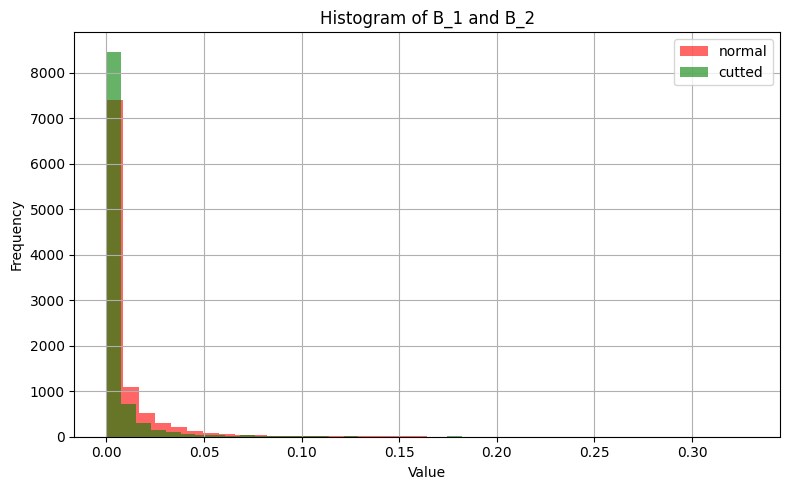

0.3036981134806967
b2 10000 b2bis 10000

 25

 9999


In [8]:
plt.figure(figsize=(8, 5))
#plt.hist(B_1_m, bins=18, alpha=0.6, label='B_1', color='blue')
plt.hist(B_3_m, bins=40, alpha=0.6, label='normal', color='red')
plt.hist(B_2_m_bis, bins=40, alpha=0.6, label='cutted', color='green')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of B_1 and B_2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print(np.max(B_2_m_bis))
print("b2", len(B_2_m), "b2bis", len(B_2_m_bis))
print("\n",sum(1 for x in B_2_m if x > 0))
print("\n",sum(1 for x in B_2_m_bis if x > 0))

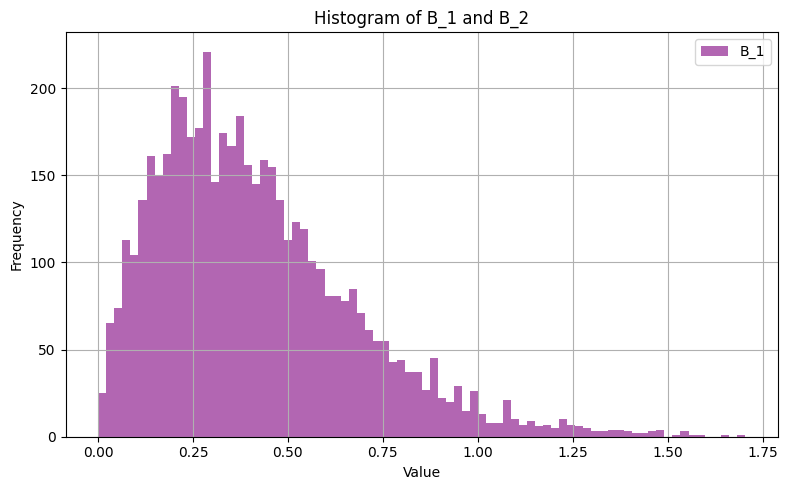

0.1635884528698182


In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(I, bins=80, alpha=0.6, label='B_1', color='purple')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of B_1 and B_2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

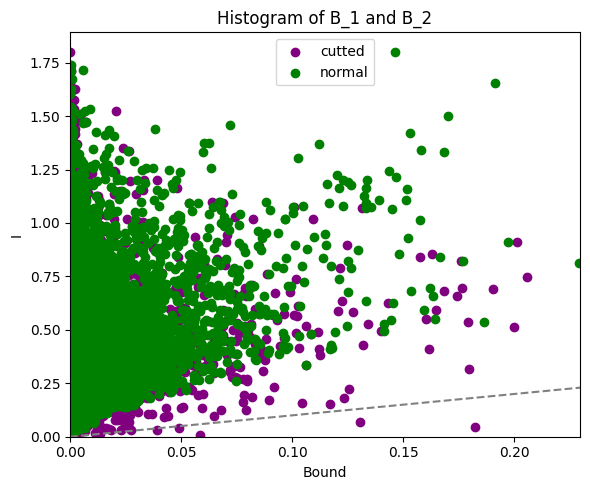

We have :  25  positive bound states


In [9]:
plt.figure(figsize=(6, 5))
plt.xlim(left=0, right=max(B_2_m)*1.05)
plt.ylim(bottom=0, top=max(I)*1.05)
plt.scatter(B_2_m_bis,I, label='cutted', color='purple')
plt.scatter(B_3_m,I, label='normal', color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Bound')
plt.ylabel('I')
plt.title('Histogram of B_1 and B_2')
plt.legend()
plt.tight_layout()
plt.show()

print("We have : ",(B_2_m > 0).sum(), " positive bound states")

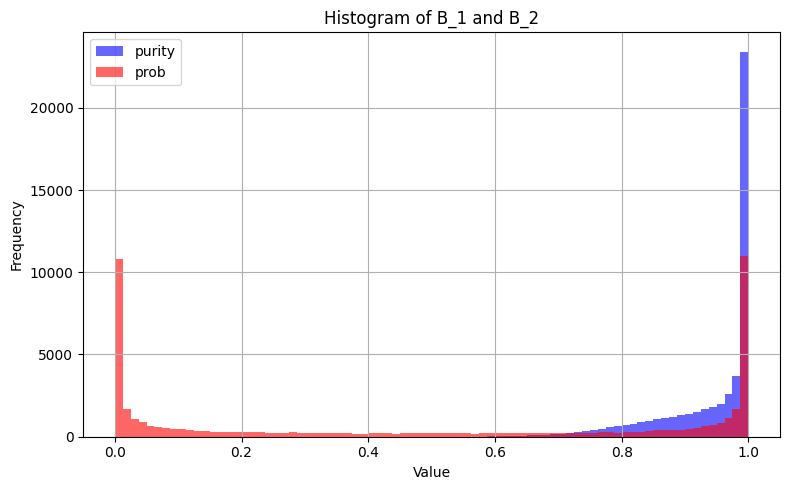

0.29479989796309425


In [14]:
plt.figure(figsize=(8, 5))
plt.hist(purity, bins=80, alpha=0.6, label='purity', color='blue')
plt.hist(P, bins=80, alpha=0.6, label='prob', color='red')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of B_1 and B_2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print(np.max(B_2_m))

# New identity, 4 - like information

In [ ]:
n = 5000
num_qubits = 3
Z = qt.sigmaz()
Z_2 = qt.tensor(Z, Z)
Z_3 = qt.tensor(Z, Z, Z)
Z_4 = qt.tensor(Z, Z, Z, Z)
Z_norm =  np.max(np.abs(Z.eigenenergies()))
B_id = np.zeros(n)

I = np.zeros(n)

purity = np.zeros(n)

for i in range(1,n):
    random_state_1 = create_random_state_4(num_qubits)
    random_state_2 = create_random_state_4(num_qubits)

    p_random_1 = compute_density_matrix(random_state_1)
    p_random_2 = compute_density_matrix(random_state_2)

    P_1, P_2= np.random.dirichlet([0.2, 0.2])
    P[i] = P_1 

    p_mixed = (P_1*p_random_1 + P_2*p_random_2) 
    #p_mixed = p_random_1

    p_A, p_B, p_C, p_AB, p_AC, p_BC = compute_reduced_density_matrices_3(p_mixed)

    avg_Z_A = (p_A * Z).tr()
    avg_Z_B = (p_B * Z).tr()
    avg_Z_C = (p_C * Z).tr()
    avg_Z_AC = (p_AC * Z_2).tr()
    avg_Z_BC = (p_BC * Z_2).tr()
    avg_Z_AB = (p_AB * Z_2).tr()
    avg_Z_full = (p_mixed * Z_full).tr()

    B_1_m[i] = ((avg_Z_full-avg_Z_A*avg_Z_B*avg_Z_C)**2/(2*Z_norm**6)-2*(qt.entropy_vn(p_C, base = 2))).real
    B_2_m[i] = 0.5*(((avg_Z_full-(avg_Z_A*avg_Z_BC))**2 + (avg_Z_full-(avg_Z_B*avg_Z_AC))**2)/(2*Z_norm**6)-2*(qt.entropy_vn(p_C, base = 2))).real
    B_3_m[i] = ((avg_Z_full-(avg_Z_A*avg_Z_BC))**2/(2*Z_norm**6) + (avg_Z_AB-(avg_Z_B*avg_Z_A))**2/(2*Z_norm**4)-2*(qt.entropy_vn(p_A,base = 2))).real
    purity[i] = (p_mixed @ p_mixed).tr()
    I[i] = qt.entropy_vn(p_AC, base = 2) + qt.entropy_vn(p_BC, base = 2) - qt.entropy_vn(p_mixed, base = 2) - qt.entropy_vn(p_C, base = 2)
    

print((B_2_m > 0).sum()/n*100)




# Random Pure states

In [20]:
n = 5000
num_qubits = 3
Z = qt.sigmaz()
Z_2 = qt.tensor(Z, Z)
Z_full = qt.tensor(Z, Z, Z)
Z_norm = 1
B_1_p = np.zeros(n)
B_2_p = np.zeros(n)

for i in range(1,n):
    random_state = create_random_state(num_qubits)
 

    p_r_1 = compute_density_matrix(random_state)


    p_A, p_B, p_C, p_AB, p_AC, p_BC = compute_reduced_density_matrices_3(p_r_1)

    avg_Z_A = (p_A * Z).tr()
    avg_Z_B = (p_B * Z).tr()
    avg_Z_C = (p_C * Z).tr()
    avg_Z_AC = (p_AC * Z_2).tr()
    avg_Z_BC = (p_BC * Z_2).tr()
    avg_Z_AB = (p_AB * Z_2).tr()
    avg_Z_full = (p_r_1* Z_full).tr()

    B_1_p[i] = ((avg_Z_full-avg_Z_A*avg_Z_B*avg_Z_C)**2/2-2*(qt.entropy_vn(p_C))).real
    B_2_p[i] = 0.5*(((avg_Z_full-(avg_Z_A*avg_Z_BC))**2 + (avg_Z_full-(avg_Z_B*avg_Z_AC))**2)/2-2*(qt.entropy_vn(p_C))).real





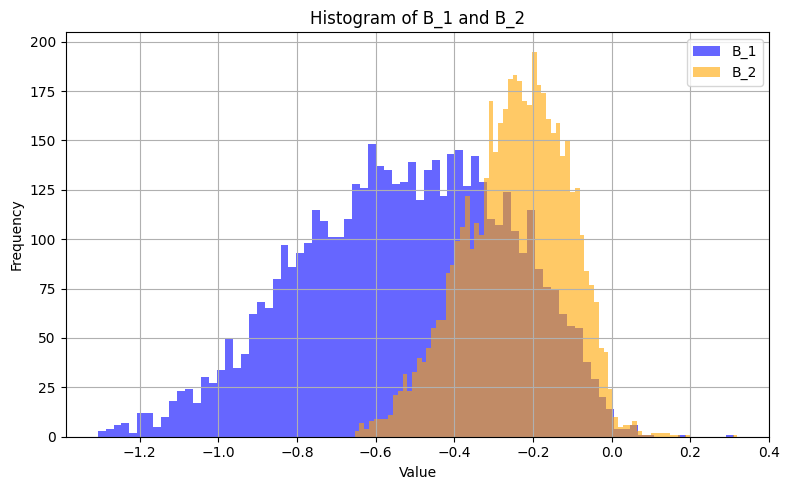

In [21]:
plt.figure(figsize=(8, 5))
plt.hist(B_1_p, bins=80, alpha=0.6, label='B_1', color='blue')
plt.hist(B_2_p, bins=80, alpha=0.6, label='B_2', color='orange')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of B_1 and B_2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# More qubits (5)

In [91]:
n = 10000
num_qubits = 5
Z = qt.sigmaz()
Z_2 = qt.tensor(Z, Z)
Z_3 = qt.tensor(Z, Z, Z)
Z_4 = qt.tensor(Z, Z, Z, Z)
Z_5 = qt.tensor(Z, Z, Z, Z, Z )
Z_norm = 1
B_1_m_5 = np.zeros(n)
B_2_m_5 = np.zeros(n)

for i in range(1,n):
    random_state_1 = create_random_state(num_qubits)
    random_state_2 = create_random_state(num_qubits)
    random_state_3 = create_random_state(num_qubits)

    p_random_1 = compute_density_matrix(random_state_1)
    p_random_2 = compute_density_matrix(random_state_2)
    p_random_3 = compute_density_matrix(random_state_3)
  

    p_mixed_5 = (1/3) * (p_random_1 + p_random_2 + p_random_3)

    p_A, p_B, p_C, p_AB, p_AC, p_BC = compute_reduced_density_matrices_5(p_mixed_5)

    avg_Z_A_5 = (p_A * Z_2).tr()
    avg_Z_B_5 = (p_B * Z_2).tr()
    avg_Z_C_5 = (p_C * Z).tr()
    avg_Z_AC_5 = (p_AC * Z_3).tr()
    avg_Z_BC_5 = (p_BC * Z_3).tr()
    avg_Z_AB_5 = (p_AB * Z_4).tr()
    avg_Z_full_5 = (p_mixed_5 * Z_5).tr()

    B_1_m_5[i] = ((avg_Z_full_5-avg_Z_A_5*avg_Z_B_5*avg_Z_C_5)**2/2-2*(qt.entropy_vn(p_C))).real
    B_2_m_5[i] = 0.5*(((avg_Z_full_5-(avg_Z_A_5*avg_Z_BC_5))**2 + (avg_Z_full_5-(avg_Z_B_5*avg_Z_AC_5))**2)/2-2*(qt.entropy_vn(p_C))).real





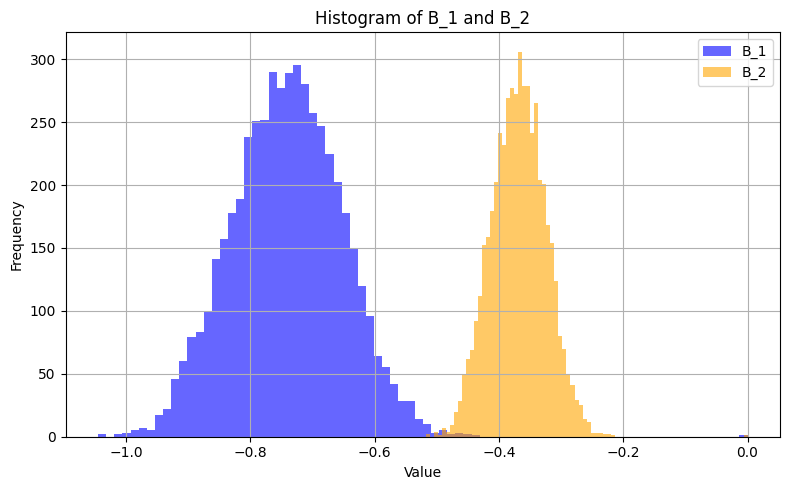

In [90]:
plt.figure(figsize=(8, 5))
plt.hist(B_1_m_5, bins=80, alpha=0.6, label='B_1', color='blue')
plt.hist(B_2_m_5, bins=80, alpha=0.6, label='B_2', color='orange')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of B_1 and B_2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Stato ingegnerizzato

In [26]:

Z = qt.sigmaz()
Z_2 = qt.tensor(Z, Z)
Z_full = qt.tensor(Z, Z, Z)

X = qt.sigmax()
X_2 = qt.tensor(X, X)
X_full = qt.tensor(X, X, X)

Z_norm = 1

# Define basis states
zero = qt.basis(2,0)
one = qt.basis(2,1)

# Pure state for subsystem C (zero entropy)
psi_C = zero # this is |0>
rho_C = psi_C * psi_C.dag()

psi_C_1 = one # this is |0>
rho_C_1 = psi_C_1 * psi_C_1.dag()

a_1 =  create_random_state(1)
rho_A_1 = a_1*a_1.dag()

b_1 =  create_random_state(1)
rho_B_1 = b_1*b_1.dag()

rho_AB_1 = qt.tensor(rho_A_1, rho_B_1)  # Correctly tensor A and B (each qubit dim=2)

a_2 =  create_random_state(1)
rho_A_2 = a_2*a_2.dag()

b_2 =  create_random_state(1)
rho_B_2 = b_2*b_2.dag()

rho_AB_2 = qt.tensor(rho_A_2, rho_B_2)  # Correctly tensor A and B (each qubit dim=2)

rho_AB = (1/2)*(rho_AB_1 + rho_AB_2)

print("\ntrace squared of rho_AB = ", (rho_AB @ rho_AB).tr())
# Combine AB and C into ABC state
#rho_ABC = qt.tensor(rho_AB, rho_C)
rho_ABC = (1/2)*(qt.tensor(rho_AB, rho_C)+qt.tensor(rho_AB, rho_C_1))

# Check the dimensions (should be 8-dimensional Hilbert space)
print("rho_ABC dimension:", rho_ABC.dims)

p_A, p_B, p_C, p_AB, p_AC, p_BC = compute_reduced_density_matrices_3(rho_ABC)

entropy_C = qt.entropy_vn(p_C)
print("Von Neumann entropy of subsystem C:", entropy_C)

avg_Z_A = (p_A * Z).tr().real
avg_Z_B = (p_B * Z).tr().real
avg_Z_C = (p_C * Z).tr().real
avg_Z_AC = (p_AC * Z_2).tr().real
avg_Z_BC = (p_BC * Z_2).tr().real
avg_Z_AB = (p_AB * Z_2).tr().real
avg_Z_full = (rho_ABC* Z_full).tr().real

avg_X_A = (p_A * X).tr().real
avg_X_B = (p_B * X).tr().real
avg_X_C = (p_C * X).tr().real
avg_X_AC = (p_AC * X_2).tr().real
avg_X_BC = (p_BC * X_2).tr().real
avg_X_AB = (p_AB * X_2).tr().real
avg_X_full = (rho_ABC* X_full).tr().real

# Build rows
rows = [
    ("A", avg_Z_A),
    ("B", avg_Z_B),
    ("C", avg_Z_C),
    ("A+C", avg_Z_AC),
    ("B+C", avg_Z_BC),
    ("A+B", avg_Z_AB),
    ("A+B+C", avg_Z_full),
]

# Print header
print("{:<10} {:>10}".format("Subsystem", "⟨Z⟩"))
print("-" * 22)

# Print each row
for label, value in rows:
    print("{:<10} {:>10.5f}".format(label, float(value)))

# Build rows
rows = [
    ("A", avg_X_A),
    ("B", avg_X_B),
    ("C", avg_X_C),
    ("A+C", avg_X_AC),
    ("B+C", avg_X_BC),
    ("A+B", avg_X_AB),
    ("A+B+C", avg_X_full),
]

# Print header
print("{:<10} {:>10}".format("\n\nSubsystem", "⟨X⟩"))
print("-" * 22)

# Print each row
for label, value in rows:
    print("{:<10} {:>10.5f}".format(label, float(value)))


B_1_s = ((avg_X_full-avg_X_A*avg_X_B*avg_Z_C)**2/2-2*(qt.entropy_vn(p_C))).real
B_2_s = 0.5*(((avg_Z_full-(avg_Z_A*avg_Z_BC))**2 + (avg_Z_full-(avg_Z_B*avg_Z_AC))**2)/2-2*(qt.entropy_vn(p_C))).real

print("Bound 1 = ",B_1_s)
print("Bound 2 = ",B_2_s)




trace squared of rho_AB =  0.7669356182014468
rho_ABC dimension: [[2, 2, 2], [2, 2, 2]]
Von Neumann entropy of subsystem C: 0.6931471805599453
Subsystem         ⟨Z⟩
----------------------
A             0.34021
B            -0.70029
C             0.00000
A+C           0.00000
B+C           0.00000
A+B          -0.32463
A+B+C         0.00000


Subsystem        ⟨X⟩
----------------------
A             0.66525
B             0.68252
C             0.00000
A+C           0.00000
B+C           0.00000
A+B           0.49938
A+B+C         0.00000
Bound 1 =  -1.3862943611198906
Bound 2 =  -0.6931471805599453


# We do some statistics to understand what combo of Operators is the best one

In [64]:
n = 10000
num_qubits = 2
theta = np.pi/4
#Z = np.cos(theta) * qt.sigmaz() + np.sin(theta) * qt.sigmax()

Z = qt.sigmaz()
Z_2 = qt.tensor(Z, Z)
Z_full = qt.tensor(Z, Z, Z)

X = qt.sigmax()
X_2 = qt.tensor(X, X)
X_full = qt.tensor(X, X, X)

mix_full = qt.tensor(X, Z, Z)

Z_norm = 1

# Define basis states
zero = qt.basis(2,0)
one = qt.basis(2,1)

B_1_Zfull = np.zeros(n)
B_2_Zfull = np.zeros(n)
B_3_Zfull = np.zeros(n)
B_1_cind = np.zeros(n)
c_entropy = np.zeros(n)
c_entropy_pb = np.zeros(n)
c_entropy_classic = np.zeros(n)

positive_part_1 = np.zeros(n)
positive_part_2 = np.zeros(n)
positive_part_3 = np.zeros(n)

psi_C_0 = zero # this is |0>
rho_C_0 = psi_C_0 * psi_C_0.dag()

psi_C_1 = one # this is |1>
rho_C_1 = psi_C_1 * psi_C_1.dag()

purities = np.zeros(n)
pos_bound_purities = np.zeros(n)
desity = np.zeros(n)

I = np.zeros(n)


#proj_0 = qt.basis(2, 0) * qt.basis(2, 0).dag()
#proj_1 = qt.basis(2, 1) * qt.basis(2, 1).dag()
#projectors = [proj_0, proj_1]

eigvals, eigvecs = Z.eigenstates()
projectors = [vec * vec.dag() for vec in eigvecs]


for i in range(1,n):

    p_full = 0

    random_state_1 = create_random_state(num_qubits)
    p_1 = compute_density_matrix(random_state_1)
    random_state_2 = create_random_state(num_qubits)
    p_2 = compute_density_matrix(random_state_2)
    random_state_3 = create_random_state(num_qubits)
    p_3 = compute_density_matrix(random_state_1)
    random_state_4 = create_random_state(num_qubits)
    p_4 = compute_density_matrix(random_state_2)
    p_mix_1 = (1/2)*(p_1 + p_2)
    p_mix_2 = (1/2)*(p_3 + p_4)

    #P = np.random.rand()
    #P = 0.5
    P = sample_single_p_with_uniform_entropy()
    
    p_full = P*qt.tensor(p_mix_1,rho_C_1)+(1-P)*qt.tensor(p_mix_2,rho_C_0)
    p_A, p_B, p_C, p_AB, p_AC, p_BC = compute_reduced_density_matrices_3(p_full)

    avg_Z_A = (p_A * Z).tr()
    avg_Z_B = (p_B * Z).tr()
    avg_Z_C = (p_C * Z).tr()
    avg_Z_AC = (p_AC * Z_2).tr()
    avg_Z_BC = (p_BC * Z_2).tr()
    avg_Z_AB = (p_AB * Z_2).tr()
    avg_Z_full = (p_full* Z_full).tr()

    '''
    avg_X_A = (p_A * X).tr().real
    avg_X_B = (p_B * X).tr().real
    avg_X_C = (p_C * X).tr().real
    avg_X_AC = (p_AC * X_2).tr().real
    avg_X_BC = (p_BC * X_2).tr().real
    avg_X_AB = (p_AB * X_2).tr().real
    avg_X_full = (p_full* X_full).tr().real

    avg_mix_full = (p_full* mix_full).tr().real

    '''

    probs = [ (p_C * Pr).tr().real for Pr in projectors ] # questo pesca i valori sulla diagonale

    c_entropy_classic[i] = shannon_entropy(probs)

    purities[i] = (p_full @ p_full).tr()
    desity[i] = p_full.tr()
    B_1_Zfull[i] = ((avg_Z_full-avg_Z_A*avg_Z_B*avg_Z_C)**2/2-2*(qt.entropy_vn(p_C, base = 2))).real
    B_2_Zfull[i] = 0.5*(((avg_Z_full-(avg_Z_A*avg_Z_BC))**2 + (avg_Z_full-(avg_Z_B*avg_Z_AC))**2)/2-2*(qt.entropy_vn(p_C, base = 2))).real
    B_3_Zfull[i] = (((avg_Z_full-(avg_Z_A*avg_Z_BC))**2 + (avg_Z_full-(avg_Z_B*avg_Z_A))**2)/2-2*(qt.entropy_vn(p_A, base = 2))).real
    #B_1_cind[i] = ((avg_mix_full-avg_X_A*avg_Z_B*avg_Z_C)**2/2-2*(qt.entropy_vn(p_C))).real
    positive_part_2[i] = (((avg_Z_full-(avg_Z_A*avg_Z_BC))**2 + (avg_Z_full-(avg_Z_B*avg_Z_AC))**2)/2).real
    positive_part_1[i] = ((avg_Z_full-avg_Z_A*avg_Z_B*avg_Z_C)**2/2).real
    positive_part_3[i] = (((avg_Z_full-(avg_Z_A*avg_Z_BC))**2 + (avg_Z_full-(avg_Z_B*avg_Z_A))**2)/2).real
    c_entropy[i] = qt.entropy_vn(p_C, base = 2)
    if B_2_Zfull[i] > 0:
        pos_bound_purities[i] = (p_full @ p_full).tr()
        c_entropy_pb[i] = qt.entropy_vn(p_C, base = 2)

    I[i] = qt.entropy_vn(p_AC, base = 2) + qt.entropy_vn(p_BC, base = 2) - qt.entropy_vn(p_mixed, base = 2) - qt.entropy_vn(p_C, base = 2)

    
        


if np.max(B_2_Zfull)>0:
    print("yes")

filtered = pos_bound_purities[pos_bound_purities != 0]
filtered_entropy = c_entropy_pb[c_entropy_pb != 0]



yes


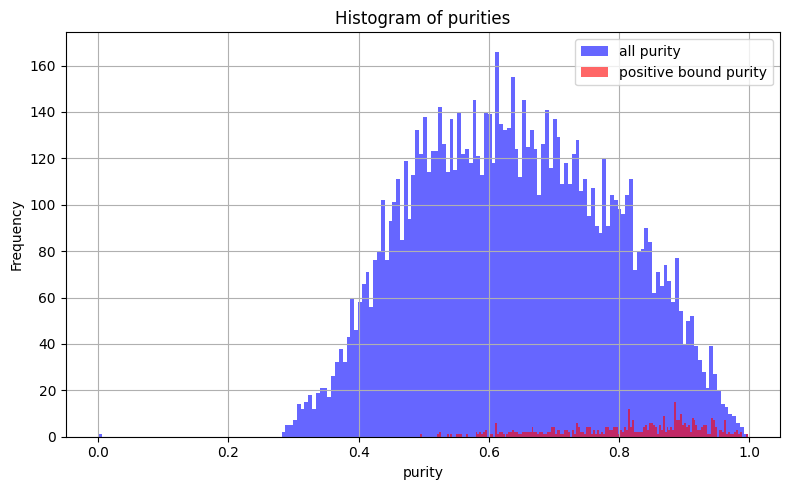

0.49367578328532136


In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(purities, bins=170, alpha=0.6, label='all purity', color='blue')
plt.hist(filtered, bins=170, alpha=0.6, label='positive bound purity', color='red')
plt.xlabel('purity')
plt.ylabel('Frequency')
plt.title('Histogram of purities')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


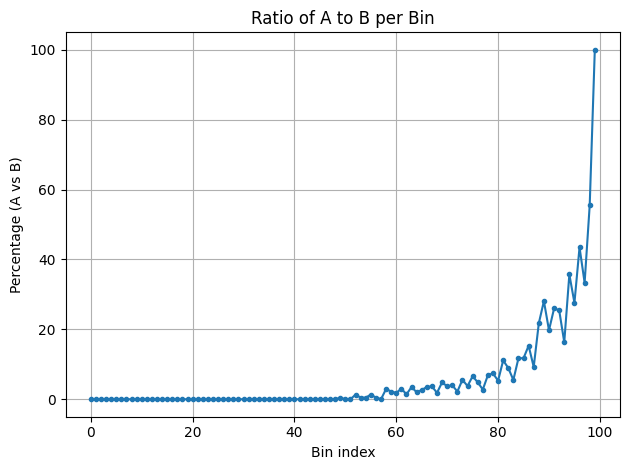

In [66]:
n = 100
m = compute_ratio_per_bin(purities,filtered,n)

N = range(n)

# Line plot over bin index
plt.plot(N, m, marker='.')
plt.xlabel('Bin index')
plt.ylabel('Percentage (A vs B)')
plt.title('Ratio of A to B per Bin')
plt.grid(True)
plt.tight_layout()
plt.show()

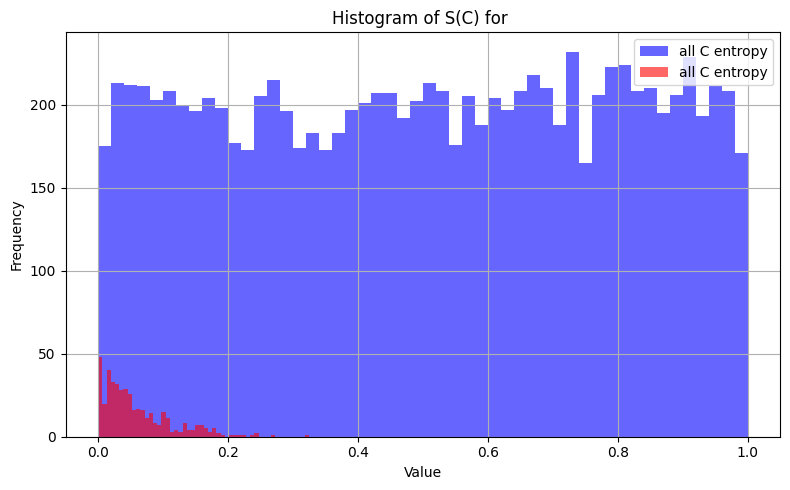

In [67]:
plt.figure(figsize=(8, 5))
plt.hist(c_entropy, bins=50, alpha=0.6, label='all C entropy', color='blue')
plt.hist(filtered_entropy, bins=50, alpha=0.6, label='all C entropy', color='red')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of S(C) for ')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

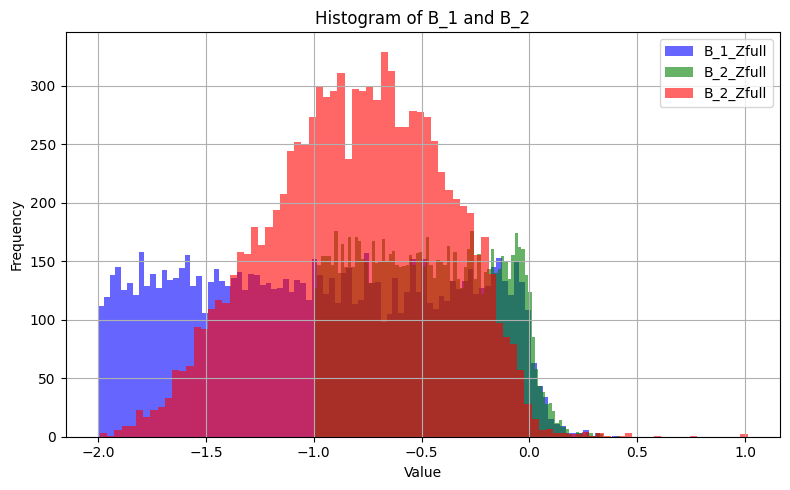

In [68]:
plt.figure(figsize=(8, 5))
plt.hist(B_1_Zfull, bins=90, alpha=0.6, label='B_1_Zfull', color='blue')
plt.hist(B_2_Zfull, bins=90, alpha=0.6, label='B_2_Zfull', color='green')
plt.hist(B_3_Zfull, bins=90, alpha=0.6, label='B_2_Zfull', color='red')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of B_1 and B_2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

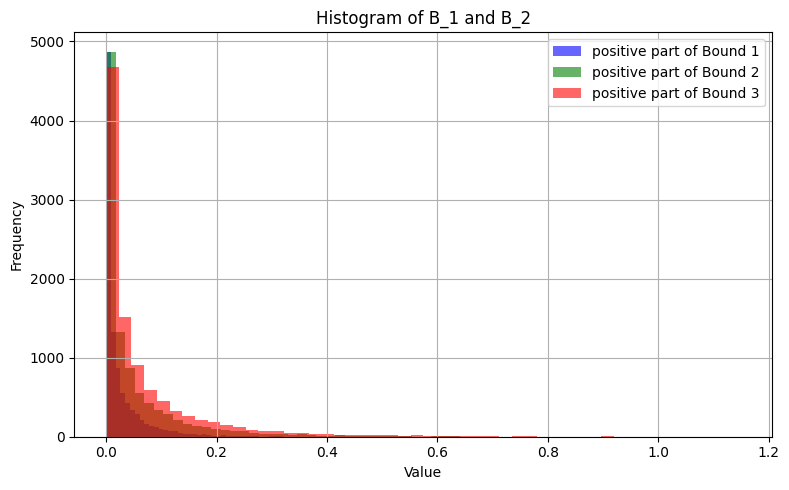

In [69]:
plt.figure(figsize=(8, 5))
plt.hist(positive_part_1, bins=50, alpha=0.6, label='positive part of Bound 1', color='blue')
plt.hist(positive_part_2, bins=50, alpha=0.6, label='positive part of Bound 2', color='green')
plt.hist(positive_part_3, bins=50, alpha=0.6, label='positive part of Bound 3', color='red')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of B_1 and B_2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

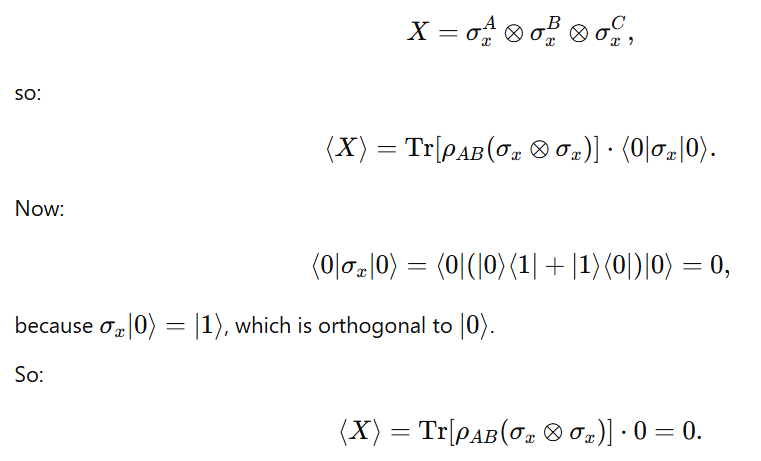

5.31


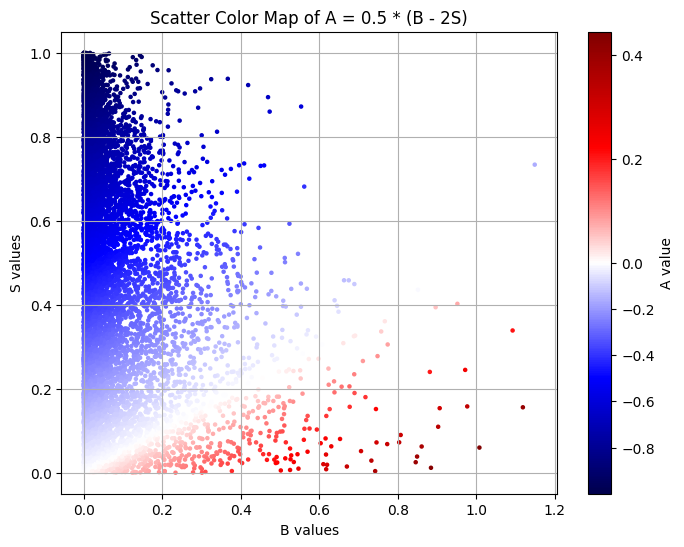

In [70]:


B = positive_part_3
S = c_entropy

A = 0.5 * (B - 2 * S)

norm = mcolors.TwoSlopeNorm(vmin=min(A), vcenter=0, vmax=max(A))
print( 100 * np.sum(A > 0) / len(A))
plt.figure(figsize=(8,6))
sc = plt.scatter(B, S, c=A, cmap='seismic', s=5, norm = norm)
plt.colorbar(sc, label='A value')
plt.xlabel('B values')
plt.ylabel('S values')
plt.title('Scatter Color Map of A = 0.5 * (B - 2S)')
plt.grid(True)
plt.show()

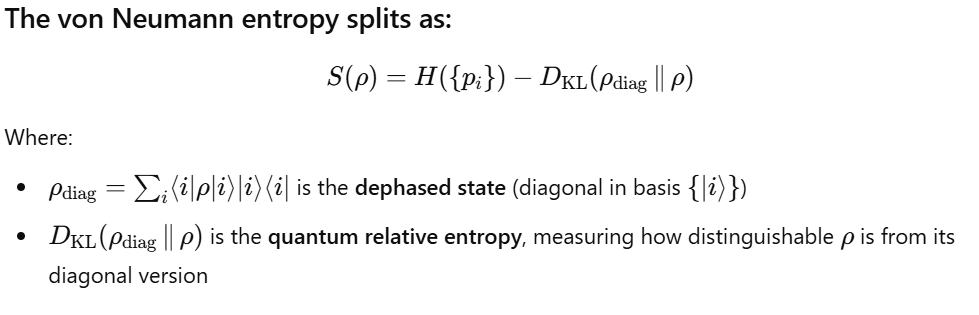
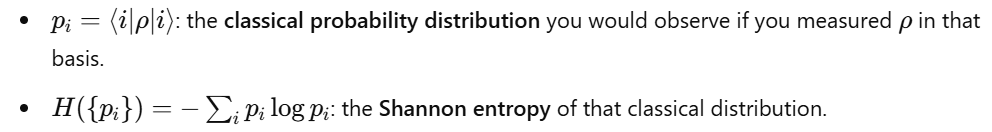

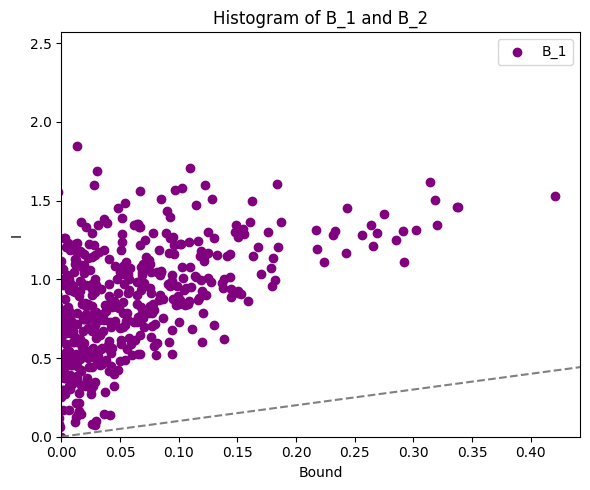

Wer have :  4.36  positive bound states


In [ ]:

plt.figure(figsize=(6, 5))
plt.xlim(left=0, right=max(B_2_Zfull)*1.05)
plt.ylim(bottom=0, top=max(I)*1.05)
plt.scatter(B_2_Zfull,I, label='B_1', color='purple')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Bound')
plt.ylabel('I')
plt.title('Histogram of B_1 and B_2')
plt.legend()
plt.tight_layout()
plt.show()

print("We have : ",((B_2_Zfull > 0).sum())/n, " positive bound states")